<a href="https://colab.research.google.com/github/bhushanrajs/distribution_factors_pySR/blob/main/df_skew_correction_PySR_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic Regression

In [3]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.5"
export JULIA_PKG_PRECOMPILE_AUTO=0
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  echo "Installing PyCall.jl..."
  julia -e 'using Pkg; Pkg.add("PyCall"); Pkg.build("PyCall")'
  julia -e 'println("Success")'

fi

Installing Julia 1.8.5 on the current Colab Runtime...
2024-07-18 15:45:54 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.5-linux-x86_64.tar.gz [130873886/130873886] -> "/tmp/julia.tar.gz" [1]
Installing PyCall.jl...
  Installing known registries into `~/.julia`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed VersionParsing ── v1.3.0
   Installed MacroTools ────── v0.5.13
   Installed Parsers ───────── v2.8.1
   Installed Conda ─────────── v1.10.2
   Installed JSON ──────────── v0.21.4
   Installed PyCall ────────── v1.96.4
   Installed Preferences ───── v1.4.3
   Installed PrecompileTools ─ v1.2.1
    Updating `~/.julia/environments/v1.8/Project.toml`
  [438e738f] + PyCall v1.96.4
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [8f4d0f93] + Conda v1.10.2
  [682c06a0] + JSON v0.21.4
  [1914dd2f] + MacroTools v0.5.13
  [69de0a69] + Parsers v2.8.1
  [aea7be01] + PrecompileTools v1.2.1
  [21216c

Install PySR and PyTorch-Lightning:

In [4]:
%pip install -Uq pysr pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 41.8 MB/s eta 0:00:00


In [5]:
%pip install julia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.1 MB/s eta 0:00:00


In [6]:
from julia import Julia

julia = Julia(compiled_modules=False, threads="auto")
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()

In [ ]:
import pysr

# We don't precompile in colab because compiled modules are incompatible static Python libraries:
pysr.install(precompile=False)

[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliapkg/juliapkg.json
[juliapkg] Locating Julia ~1.6.7, ~1.7, ~1.8, ~1.9, =1.10.0, ~1.10.3
[juliapkg] Using Julia 1.8.5 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d"), Pkg.PackageSpec(name="SymbolicRegression", uuid="8254be44-1295-4e6a-a16d-46603ac705cb"), Pkg.PackageSpec(name="Serialization", uuid="9e88b42a-f829-5b0c-bbe9-9e923198166b")])
           julia> Pkg.resolve()
           julia> Pkg.precompile()


In [3]:
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import pickle


In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/bhushanrajs/distribution_factors_pySR/main/psc_i.csv')

In [5]:
print(df.head(5))

                             model  skew girderName   L   D  w_oh    ts  S  \
0   Tx28-L_42-Nb_4-S_60-O_15-ts_85     0       Tx28  42  28   1.5   8.5  6   
1  Tx28-L_42-Nb_4-S_60-O_15-ts_100     0       Tx28  42  28   1.5  10.0  6   
2   Tx28-L_42-Nb_4-S_60-O_20-ts_85     0       Tx28  42  28   2.0   8.5  6   
3  Tx28-L_42-Nb_4-S_60-O_20-ts_100     0       Tx28  42  28   2.0  10.0  6   
4   Tx28-L_42-Nb_4-S_60-O_25-ts_85     0       Tx28  42  28   2.5   8.5  6   

   Nb           Kg  ...     n_bm4      n_r1      n_r2      n_r3      n_r4  \
0   4  555508.7064  ...  0.000520  0.925505  0.086994  0.026596 -0.039095   
1   4  588747.3095  ...  0.000889  0.923853  0.093144  0.036185 -0.053182   
2   4  555508.7064  ...  0.000448  0.993568  0.023006  0.024837 -0.041411   
3   4  588747.3095  ...  0.000803  0.991692  0.031001  0.033527 -0.056219   
4   4  555508.7064  ...  0.000379  1.060984 -0.039607  0.022209 -0.043585   

     sum_RY      d-G1      d-G2      d-G3          d-G4  
0  0.00003

In [6]:
df['x_trial'] = ((df['S']+df['w_oh'])*np.tan(np.radians(df['skew'])))/df['L']

girderName = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'girderName'].values
L = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'L'].values
D = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'D'].values
S = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'S'].values
w_oh = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'w_oh'].values
ts = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'ts'].values
Nb = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'Nb'].values
Kg = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'Kg'].values
skew = df.loc[(df['skew'] == 60), 'skew'].values * np.pi / 180
O = (w_oh * 10).astype(int)
tss = (ts * 10).astype(int)
models = girderName + '-L_' + L.astype(str) + '-Nb_' + Nb.astype(str) + '-S_' + (S*10).astype(str) + '-O_' + O.astype(str) + '-ts_' + tss.astype(str)
print(models)

skews = [30, 45, 60]
sk_bm1_correction,sk_bm2_correction, sk_r1_correction, sk_r2_correction  = [], [], [], [],
x_L, x_S, x_D, x_Nb, x_skew, x_w_oh, x_trial, x_tan_skew, x_AR = [], [], [], [], [], [], [], [], []

for skew in skews:
  for model in models:
    skew_model = model + '-sk_' + str(skew)
    normal_model = model
    n_bm1_skewed = df.loc[(df['model'] == skew_model) , 'n_bm1'].values
    n_bm1_normal = df.loc[(df['model'] == normal_model) , 'n_bm1'].values
    n_bm2_skewed = df.loc[(df['model'] == skew_model) , 'n_bm2'].values
    n_bm2_normal = df.loc[(df['model'] == normal_model) , 'n_bm2'].values
    n_r1_skewed = df.loc[(df['model'] == skew_model) , 'n_r1'].values
    n_r1_normal = df.loc[(df['model'] == normal_model) , 'n_r1'].values
    n_r2_skewed = df.loc[(df['model'] == skew_model) , 'n_r2'].values
    n_r2_normal = df.loc[(df['model'] == normal_model) , 'n_r2'].values
    sk_bm1_correction.extend(n_bm1_skewed / n_bm1_normal)
    sk_bm2_correction.extend(n_bm2_skewed / n_bm2_normal)
    sk_r1_correction.extend(n_r1_skewed / n_r1_normal)
    sk_r2_correction.extend(n_r2_skewed / n_r2_normal)
    x_L.extend(df.loc[(df['model'] == skew_model) , 'L'].values)
    x_S.extend(df.loc[(df['model'] == skew_model) , 'S'].values)
    x_D.extend(df.loc[(df['model'] == skew_model) , 'D'].values)
    x_Nb.extend(df.loc[(df['model'] == skew_model) , 'Nb'].values)
    x_skew.extend(df.loc[(df['model'] == skew_model) , 'skew'].values * np.pi / 180)
    # x_tan_skew.extend(np.tan(df.loc[(df['model'] == skew_model) , 'skew'].values * np.pi / 180))
    x_w_oh.extend(df.loc[(df['model'] == skew_model) , 'w_oh'].values)
    x_trial.extend(df.loc[(df['model'] == skew_model) , 'x_trial'].values)


['Tx28-L_42-Nb_4-S_60-O_15-ts_85' 'Tx28-L_42-Nb_4-S_60-O_20-ts_85'
 'Tx28-L_42-Nb_4-S_60-O_25-ts_85' ... 'Tx84-L_210-Nb_7-S_120-O_36-ts_85'
 'Tx84-L_210-Nb_7-S_120-O_48-ts_85' 'Tx84-L_210-Nb_7-S_120-O_60-ts_85']


In [7]:
x_tan_skew = np.tan(x_skew)
x_cos_skew = np.cos(x_skew)
x_sin_skew = np.sin(x_skew)
print(sk_r1_correction[2304:])
print(x_skew)
print(x_tan_skew)

[1.1267781697326704, 1.0664851732421914, 1.0107055723044707, 0.966394284508426, 1.0331319184125898, 1.00052067873548, 1.0465300582322241, 1.0889794854839523, 1.009419621981651, 1.0465479588659616, 1.0847276156135186, 1.1200367176282497, 1.2485091975959965, 1.1895821438134393, 1.1354103571418066, 1.085026387212314, 1.1077434388239578, 1.050405841791495, 0.997135733583743, 0.9680875083568119, 1.0418997195823292, 0.9944926811454007, 1.0048613140577212, 1.0402975913129113, 1.3721345430807996, 1.3125595698181913, 1.2583419279740737, 1.2079057967092597, 1.1922427736247678, 1.1366733665849926, 1.0851885735431677, 1.0370949626539192, 1.0983014733547056, 1.0535639883308565, 1.0113137733494406, 0.9712973622254487, 1.1571235986169868, 1.1024005308167804, 1.0514945736219976, 1.0039592439837683, 1.0528499353047458, 0.9854367813579458, 1.040743101044214, 1.091299945311964, 1.0168185308141606, 1.03337268025394, 1.0782576721611141, 1.1191771856636843, 1.288527686508389, 1.2342003285876226, 1.184112883

In [8]:
X = np.stack((x_L, x_S, x_w_oh, x_tan_skew), axis=-1)
y = sk_r1_correction
print(X.shape)
# print(y.shape)
print(X)

(3456, 4)
[[ 42.           6.           1.5          0.57735027]
 [ 42.           6.           2.           0.57735027]
 [ 42.           6.           2.5          0.57735027]
 ...
 [210.          12.           3.61111111   1.73205081]
 [210.          12.           4.80555556   1.73205081]
 [210.          12.           6.           1.73205081]]


In [14]:
# Learn equations
default_pysr_params = dict(
    populations=50,
    model_selection="best",
)

# model = PySRRegressor(
#     niterations=30,
#     binary_operators=['+', '-', '*', '/', '^'],
#     unary_operators=["square", "cube", "sqrt"],
#     **default_pysr_params
# )

model = PySRRegressor(
    niterations=400,  # < Increase me for better results
    binary_operators=['+', '-', '*', '/'],
    unary_operators=["square", "sqrt"],
        # ^ Custom operator (julia syntax)
    extra_sympy_mappings={"inv": lambda x: 1 / x,
                          "physics": lambda x, y: x**2 / y},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    constraints = {'^':(-4,4),'mult' : (3,3)},
    # ^ Custom loss function (julia syntax)
    **default_pysr_params
)

In [15]:
model.fit(X, y)
print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!


Streaming output truncated to the last 5000 lines.
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.466e-02  1.594e+01  y = 1.1325
5           8.599e-03  1.333e-01  y = 0.862 + (2.2468 / x₁)
6           8.572e-03  3.130e-03  y = 0.9938 + (8.8374 / square(x₁))
7           5.700e-03  4.080e-01  y = (sqrt(x₀) / square(x₁)) + 0.97524
8           5.079e-03  1.153e-01  y = 0.99807 + ((x₀ * 0.081969) / square(x₁))
9           4.332e-03  1.592e-01  y = 0.97144 + ((x₀ * 0.032351) / (x₂ * x₁))
10          4.056e-03  6.569e-02  y = ((x₀ * 0.055358) / square(x₃ - x₁)) + 1.0054
11          3.241e-03  2.243e-01  y = ((x₀ * 0.026877) / ((x₁ - x₃) * x₂)) + 0.97404
12          3.101e-03  4.432e-02  y = 0.97519 + ((((0.030818 / x₂) * x₀) * sqrt(x₃)) / x₁)
13          2.663e-03  1.523e-01  y = sqrt(((x₀ / x₂) / square((-2.8166 / x₃) - x₁)) + 0.9545)
15          2.497e-03  3.206e-02  y 

In [16]:
n = 8
model.sympy(n)


x0*0.13881038/(x1 + x2 - x3)**2 + 0.97155184

In [17]:
y_pred = model.predict(X,n)
print("Default selection MSE:", np.power(y_pred - y, 2).mean())
r2 = r2_score(y_pred, y)
print(f"R²: {r2:.4f}")

Default selection MSE: 0.003010548895461173
R²: 0.7831


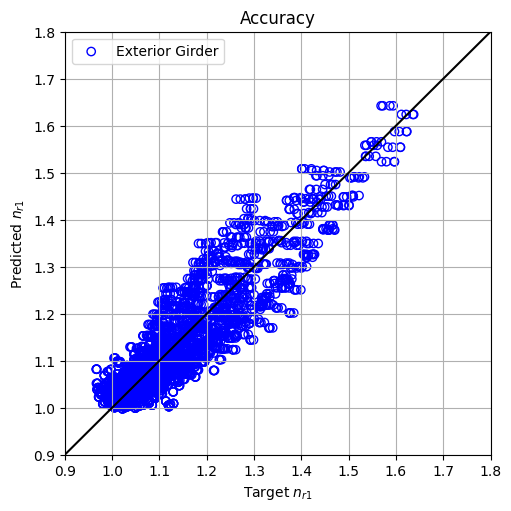

In [18]:
x_line = [0.9, 1.8]
y_line = [0.9, 1.8]
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)
ax1.scatter(x=y, y=y_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((0.9,1.8))
plt.ylim((0.9,1.8))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()

1.13246260000000
Default selection MSE: 0.014658688004571522
R²: 0.0000
0.8620024 + 2.246842/x1
Default selection MSE: 0.00859926588799029
R²: -0.4192
0.9938025 + 8.837425/(x1**2)
Default selection MSE: 0.008572389413354729
R²: -0.4085
sqrt(x0)/x1**2 + 0.97524244
Default selection MSE: 0.005700250790721744
R²: 0.3773
x0*0.08196876/x1**2 + 0.99806523
Default selection MSE: 0.005079232017633511
R²: 0.4698
x0*0.032351404/(x1*x2) + 0.97144
Default selection MSE: 0.0043316724111792755
R²: 0.5805
0.051492188*x0/((x1 - x3)**2) + 1.0106522
Default selection MSE: 0.003985991687280942
R²: 0.6261
x0*0.026876723/(x2*(x1 - x3)) + 0.97403705
Default selection MSE: 0.0032412033341738607
R²: 0.7161
x0*0.13881038/(x1 + x2 - x3)**2 + 0.97155184
Default selection MSE: 0.003010548895461173
R²: 0.7831
0.976986796226029*sqrt(0.132063689127691*x0/(x2*(-0.355042552204924*x1 - 1/x3)**2) + 1)
Default selection MSE: 0.002662635598818435
R²: 0.7920
0.976986796226029*sqrt(0.239145927771343*x0/((0.47777144465185*x1

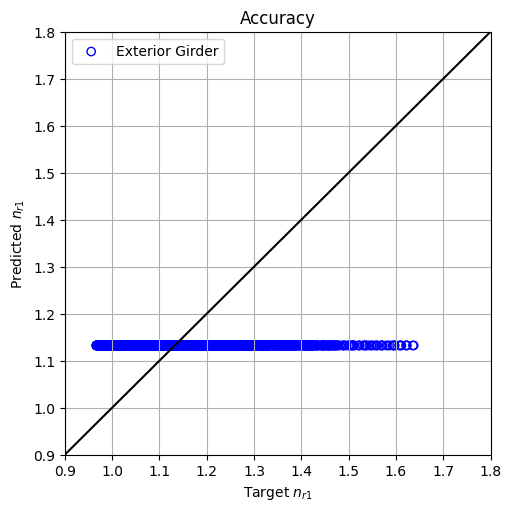

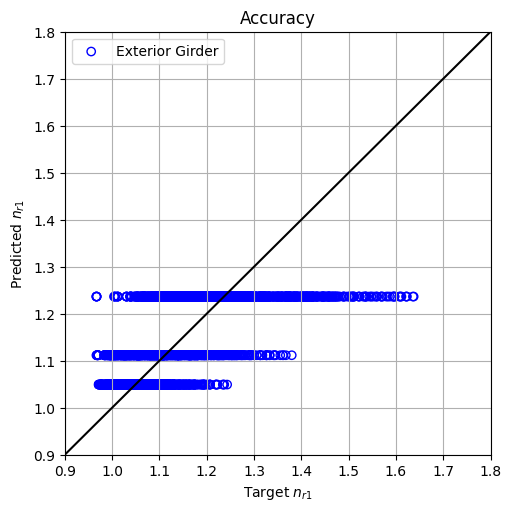

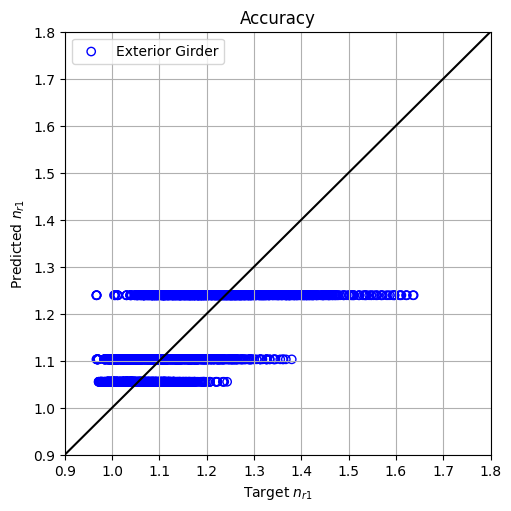

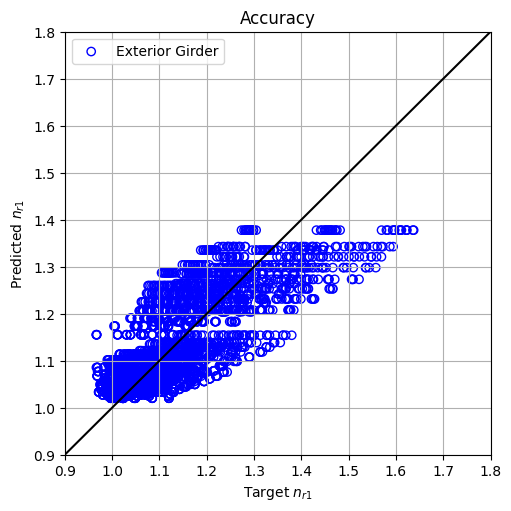

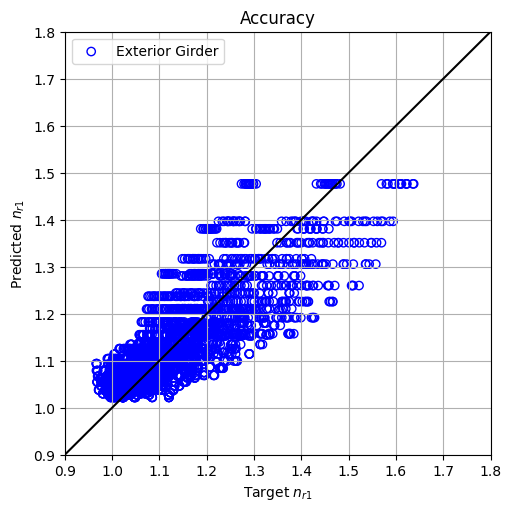

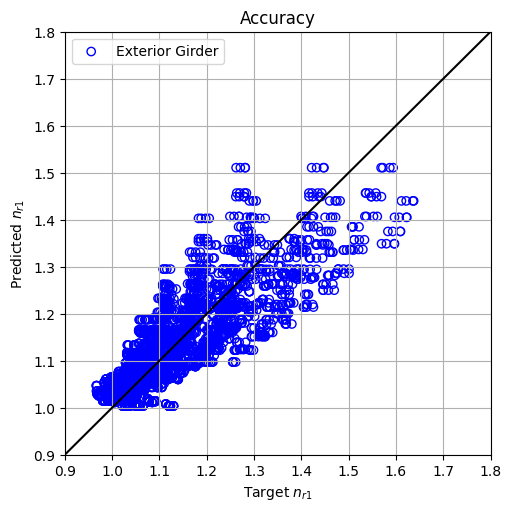

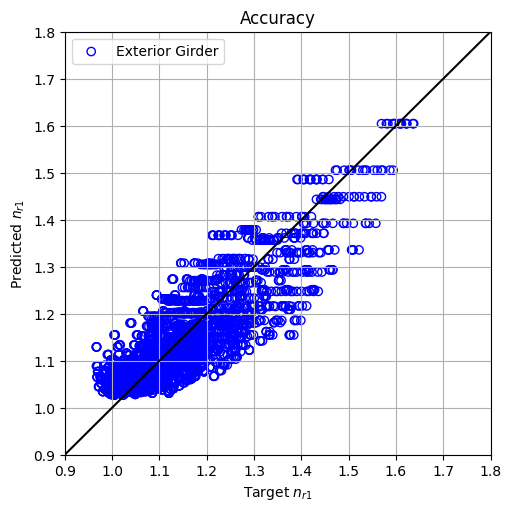

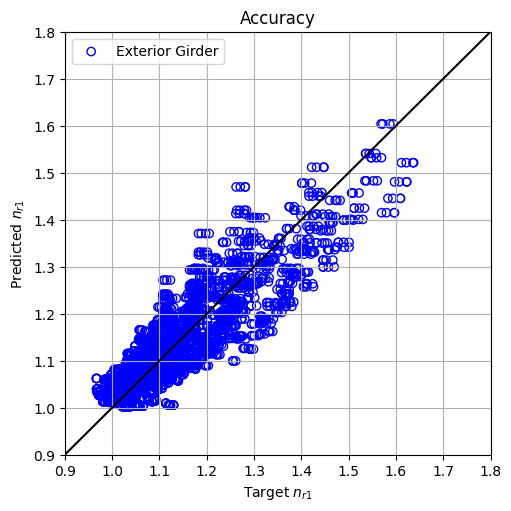

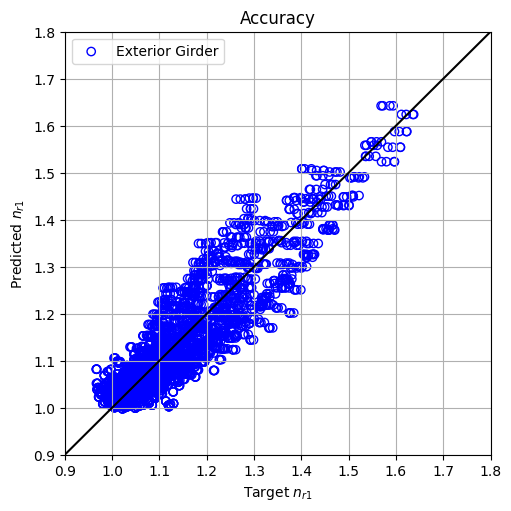

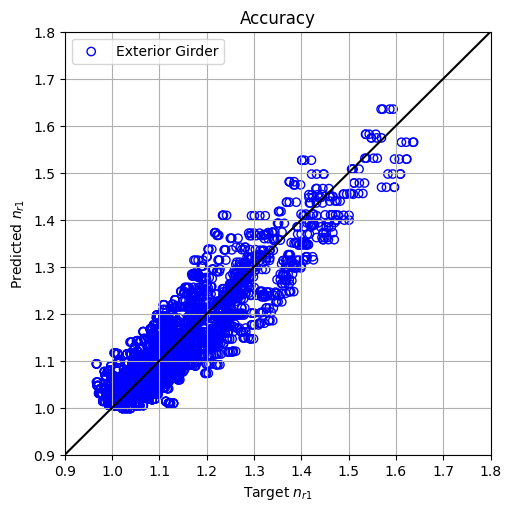

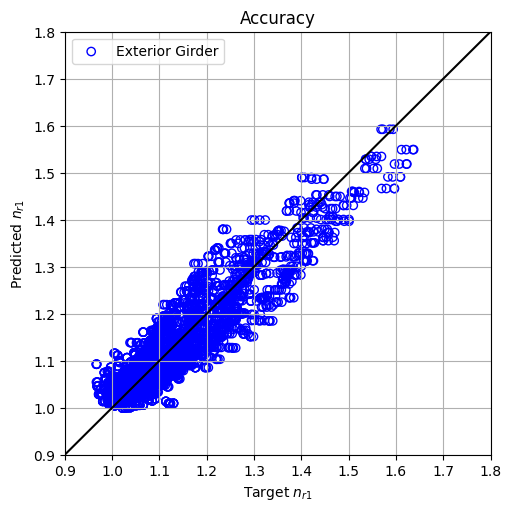

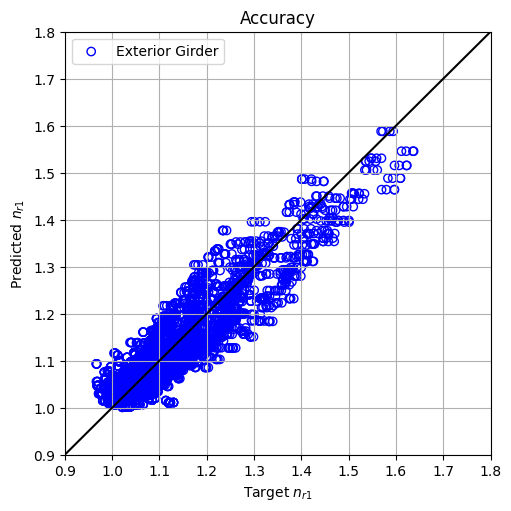

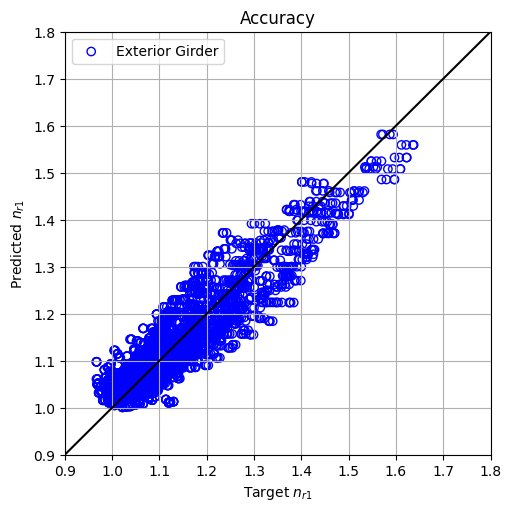

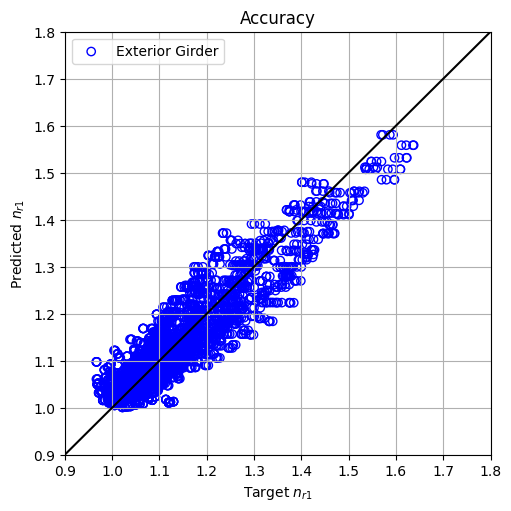

In [19]:
for i in range(14):
  print(model.sympy(i))
  y_pred = model.predict(X,i)
  print("Default selection MSE:", np.power(y_pred - y, 2).mean())
  r2 = r2_score(y_pred, y)
  print(f"R²: {r2:.4f}")
  x_line = [0.9, 1.8]
  y_line = [0.9, 1.8]
  fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)
  ax1.scatter(x=y, y=y_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
  ax1.plot(x_line, y_line, c = "k")
  ax1.set_title('Accuracy')
  ax1.legend()
  plt.xlim((0.9,1.8))
  plt.ylim((0.9,1.8))
  ax1.set_xlabel('Target $n_{r1}$')
  ax1.set_ylabel('Predicted $n_{r1}$')
  ax1.grid()

In [20]:
# save the  as a pickle file
model_pkl_file = "skew_correction_V_G1.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1124: UserWarning: `extra_sympy_mappings` cannot be pickled and will be removed from the serialized instance. When loading the model, please redefine `extra_sympy_mappings` at runtime.
  warnings.warn(


In [21]:
# load model from pickle file
with open(model_pkl_file, 'rb') as file:
    model = pickle.load(file)

# evaluate model
y_predict = model.predict(X,n)

# check results
print(y_predict)

[1.09320587 1.07736832 1.06443358 ... 1.12288047 1.09984773 1.08169959]


In [22]:
X = np.stack((x_L, x_S, x_w_oh, x_tan_skew), axis=-1)
y = sk_r2_correction
model.fit(X, y)
print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1989: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


Streaming output truncated to the last 5000 lines.
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.031e+04  1.594e+01  y = 0.20125
3           1.030e+04  2.436e-04  y = 3.123 - x₂
4           1.030e+04  1.311e-04  y = square(3.8831 - x₂)
5           1.001e+04  2.824e-02  y = -0.82738 / (x₂ - 3.5761)
7           9.033e+03  5.158e-02  y = 1.445 / (x₂ + (x₀ * -0.034168))
9           8.387e+03  3.705e-02  y = -0.16754 / (((-0.13147 + x₀) * -0.034168) + x₂)
11          8.265e+03  7.363e-03  y = (-0.16088 / (((-0.13147 + x₀) * -0.034168) + x₂)) * x₃
12          8.226e+03  4.754e-03  y = (-0.16754 / (((-0.13147 + x₀) * -0.034168) + x₂)) * sqrt(x...
                                  ₃)
13          8.217e+03  1.020e-03  y = ((-0.43631 - x₃) / (x₂ + (-0.034168 * (-0.13147 + x₀)))) /...
                                   x₁
15          8.210e+03  4.550e-04  y = (((-0.44932 - x₃) / (x₂ + (-0

0.201252940000000
Default selection MSE: 10307.463978497844
R²: -13379853208753813436172657455896985600.0000
3.1230052 - x2
Default selection MSE: 10302.442405350945
R²: -7287.2529
15.0787420879874*(1 - 0.257523842329894*x2)**2
Default selection MSE: 10301.087989332304
R²: -2615.5263
-0.83963025/(x2 - 1*3.5761027)
Default selection MSE: 10014.246056795724
R²: -33.3454
x3/(x0*(-0.034142546) + x2)
Default selection MSE: 8321.413709467424
R²: -3.2390
x3/(-0.034142546*x0 + x2) + 2.8021533
Default selection MSE: 8313.320467964117
R²: -3.2348
1.1676131*sqrt(x3)/(-0.034142546*x0 + x2)
Default selection MSE: 8298.780021936256
R²: -3.0621
-0.14813282*x3/(x2 - 0.034167565*(x0 - 0.13146985))
Default selection MSE: 8248.598035177114
R²: -3.0047
-0.17147997*sqrt(x3)/(-0.034167565*x0 + x2 + 0.00449200464541525)
Default selection MSE: 8225.307033820205
R²: -2.9035
(-x3 - 0.43631032)/(x1*(x2 - 0.034167565*(x0 - 0.13146985)))
Default selection MSE: 8217.24599696466
R²: -2.9464


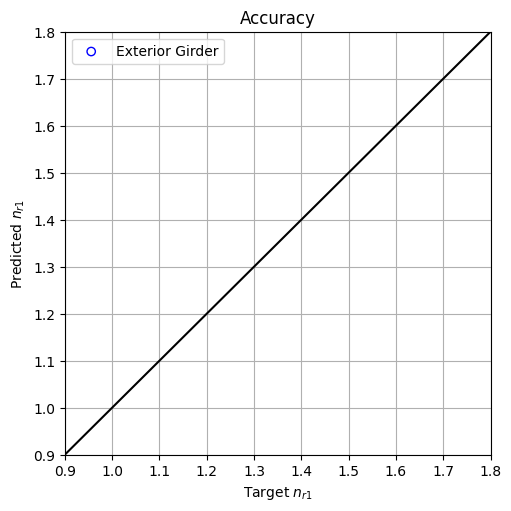

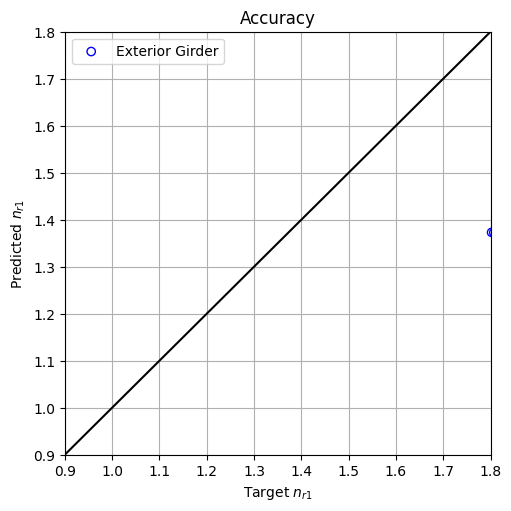

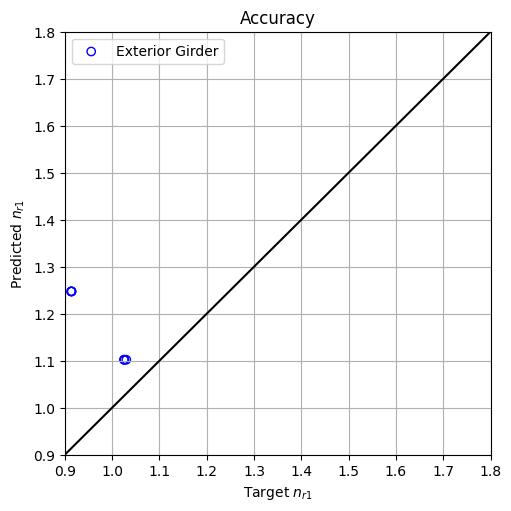

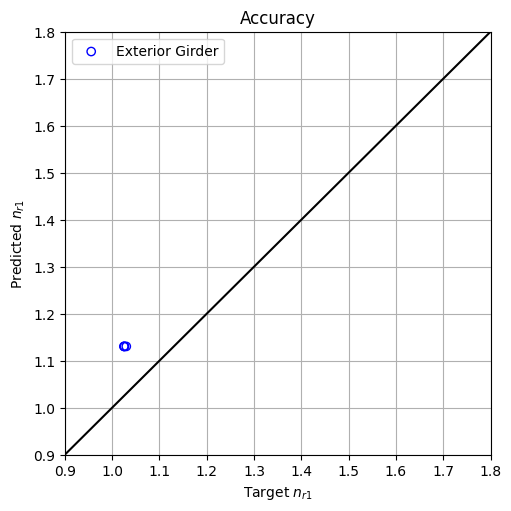

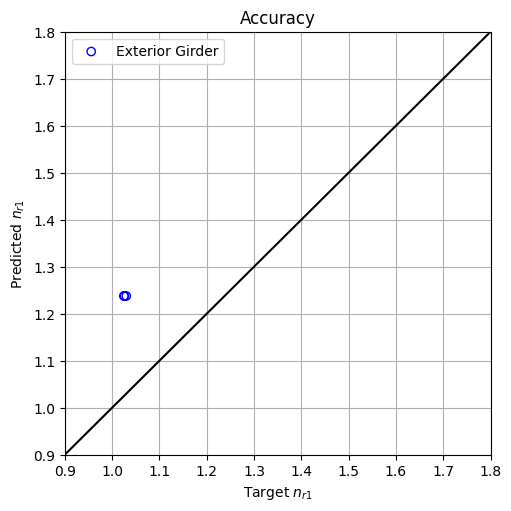

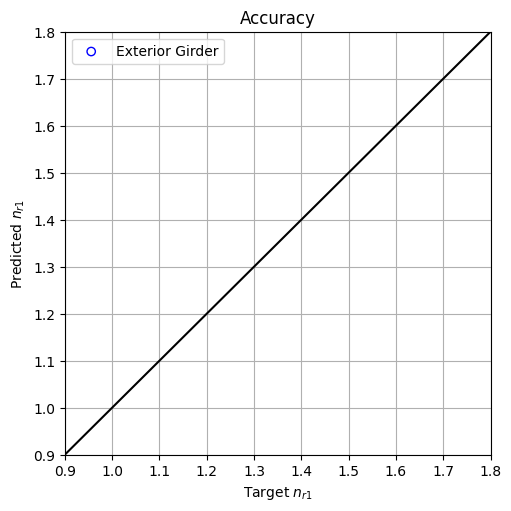

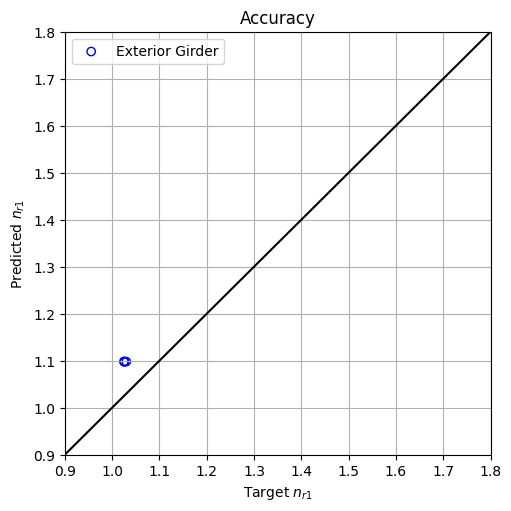

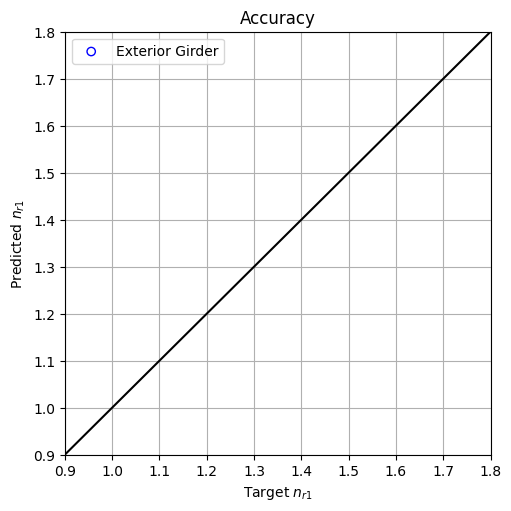

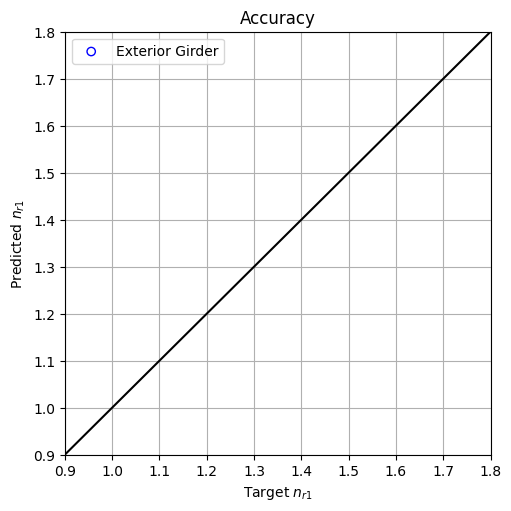

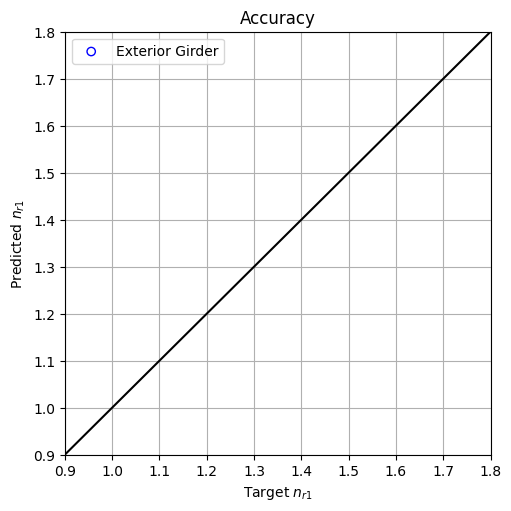

In [23]:
for i in range(10):
  print(model.sympy(i))
  y_pred = model.predict(X,i)
  print("Default selection MSE:", np.power(y_pred - y, 2).mean())
  r2 = r2_score(y_pred, y)
  print(f"R²: {r2:.4f}")
  x_line = [0.9, 1.8]
  y_line = [0.9, 1.8]
  fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)
  ax1.scatter(x=y, y=y_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
  ax1.plot(x_line, y_line, c = "k")
  ax1.set_title('Accuracy')
  ax1.legend()
  plt.xlim((0.9,1.8))
  plt.ylim((0.9,1.8))
  ax1.set_xlabel('Target $n_{r1}$')
  ax1.set_ylabel('Predicted $n_{r1}$')
  ax1.grid()

In [24]:
model_pkl_file = "skew_correction_V_G2.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

In [25]:
X = np.stack((x_L, x_S, x_w_oh, x_tan_skew), axis=-1)
y = sk_bm1_correction
model.fit(X, y)
print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1989: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


Streaming output truncated to the last 5000 lines.
16          7.619e-04  6.592e-04  y = 0.98819 - (((x₃ - 0.35985) / (sqrt(x₂) * x₁)) - (0.80345 /...
                                   (x₀ - x₁)))
17          7.595e-04  3.193e-03  y = 0.98819 - (((x₃ - 0.35985) / (sqrt(x₂) * x₁)) - (square(-0...
                                  .8213) / (x₀ - x₁)))
18          7.466e-04  1.709e-02  y = 0.99864 - ((x₃ - (square(square((x₁ * x₂) / x₀)) - -0.3301...
                                  5)) / (sqrt(x₂) * x₁))
19          7.451e-04  2.092e-03  y = square(0.99864) - ((x₃ - (square(square((x₁ * x₂) / x₀)) -...
                                   -0.33015)) / (sqrt(x₂) * x₁))
20          7.430e-04  2.746e-03  y = 0.99864 - ((x₃ - ((square((square(x₁) * x₃) / x₀) / x₀) - ...
                                  -0.33015)) / (sqrt(x₂) * x₁))
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressi

In [26]:
model_pkl_file = "skew_correction_M_G1.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

In [27]:
X = np.stack((x_L, x_S, x_w_oh, x_tan_skew), axis=-1)
y = sk_bm2_correction
model.fit(X, y)
print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1989: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


Streaming output truncated to the last 5000 lines.
Expressions evaluated per second: 2.770e+04
Head worker occupation: 10.1%
Progress: 10344 / 20000 total iterations (51.720%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           9.865e-03  1.594e+01  y = 0.94169
5           7.908e-03  5.527e-02  y = (x₃ * -0.092716) + 1.044
6           7.880e-03  3.593e-03  y = (-0.039318 * square(x₃)) - -0.99849
7           5.351e-03  3.871e-01  y = (-8.6272 / (x₀ / x₃)) + 1.049
8           5.111e-03  4.583e-02  y = sqrt(1.0917 - (x₃ / (x₀ / 16.112)))
9           4.149e-03  2.085e-01  y = (-6.3497 / ((x₀ / x₃) - x₁)) + 1.0379
10          3.646e-03  1.293e-01  y = sqrt(1.0668 + (-11.575 / ((x₀ / x₃) - x₁)))
11          2.989e-03  1.987e-01  y = square(0.99917 - (square(x₃) / (x₀ - (x₁ / 0.32644))))
12          2.682e-03  1.083e-01  y = square(square(square(x₃) / ((x₀ / 2.9008) - x₁)) - 0.9

In [28]:
model_pkl_file = "skew_correction_M_G2.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)



In [29]:
from google.colab import files
files.download('skew_correction_M_G1.pkl')
files.download('skew_correction_M_G2.pkl')
files.download('skew_correction_V_G1.pkl')
files.download('skew_correction_V_G2.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
X = np.stack((x_L, x_S, x_w_oh, x_tan_skew), axis=-1)
y = np.stack((sk_r1_correction,sk_r2_correction,sk_bm1_correction,sk_bm2_correction), axis=-1)
model.fit(X, y)
print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1989: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


Streaming output truncated to the last 5000 lines.
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           9.865e-03  1.594e+01  y₃ = 0.94169
5           7.908e-03  5.527e-02  y₃ = (-0.09276 * x₃) + 1.044
6           6.164e-03  2.492e-01  y₃ = 1.0565 - (x₃ / sqrt(x₀))
7           5.357e-03  1.403e-01  y₃ = 1.0537 - ((8.9168 / x₀) * x₃)
8           5.113e-03  4.666e-02  y₃ = sqrt(1.0886 - (x₃ / (x₀ * 0.063108)))
9           4.415e-03  1.468e-01  y₃ = square(square((x₁ / x₀) * x₃) - 0.98905)
10          3.872e-03  1.313e-01  y₃ = sqrt(1.0297 - (x₁ / ((x₀ / x₃) - x₁)))
11          2.989e-03  2.588e-01  y₃ = square(0.99922 - (square(x₃) / (x₀ - (x₁ * 3.0664))))
12          2.989e-03  -0.000e+00  y₃ = square(sqrt(0.99843) - (square(x₃) / (x₀ - (3.0664 * x₁))...
                                  ))
13          2.834e-03  5.334e-02  y₃ = square((square(x₃) / ((x₀ - (x₁ * 3.2764)) + 

In [66]:

for i in range(10):
  output_df = model.sympy([i,i,i,i])
  output_df = pd.DataFrame({'equations': model.sympy([i,i,i,i])})
  # output_df.to_csv('equations.txt', index=False)
  print(output_df)

           equations
0   1.13243440000000
1  0.201224030000000
2  0.941057000000000
3  0.941693900000000
                   equations
0   0.8620028 + 2.2468388/x1
1              3.132167 - x2
2   1.023182 - 0.07444689*x3
3  1.0440183 - 0.09275957*x3
                                           equations
0                      0.99378633 + 8.838447/(x1**2)
1     15.0817547750523*(0.257498119941852*x2 - 1)**2
2  1.00970287708811*sqrt(1 - 0.980873073160674*x3...
3                             1.056452 - x3/sqrt(x0)
                      equations
0    sqrt(x0)/x1**2 + 0.9752446
1  0.65498734/(x2 - 1*3.602346)
2      1.0401295 - x3/(x1 + x2)
3     1.053681 - 8.916816*x3/x0
                                         equations
0                  x0*0.08196872/x1**2 + 0.9980653
1                x3/((-2.2259288)*(x2 - 3.577854))
2               1.0260996 - x3/(x1 + x2*1.6716636)
3  3.98067093299457*sqrt(0.06870003710932 - x3/x0)
                                           equations
0                

In [74]:
len(model.equations_[1])

16

In [9]:
def diagonal_plot(y, y_pred, label, girder, equation, output_name, num):
    font = {'family' : 'sans-serif', 'size': 8}
    plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
    plt.rcParams['axes.xmargin'] = 0.05
    plt.rcParams['axes.ymargin'] = 0
    plt.rc('font', **font)
    markers = ['o', '^', 's', 'D','.', '*', 'x']

    x_line = [min(y) - 0.2, max(y) + 0.2]
    y_line = [min(y) - 0.2, max(y) + 0.2]
    fig, ax = plt.subplots(figsize=(3.2, 2.5))
    if girder == 'G_Ext':
        ax.scatter(x=y, y=y_pred, label=r'$\mathrm{G}_{\mathrm{Ext,N}}$', marker=markers[0], c='none', edgecolor='C0')
    else:
        ax.scatter(x=y, y=y_pred,  label=r'$\mathrm{G}_{\mathrm{Ext,N}}$', marker=markers[0], c='none', edgecolor='C1')
    ax.plot(x_line, y_line, c="k")
    r2 = r2_score(y_pred, y)

    ax.set_title('Accuracy')
    plt.xlim((min(y) - 0.1, max(y) + 0.1))
    plt.ylim((min(y) - 0.1, max(y) + 0.1))

    ax.grid()
    ax.set_xlabel(label + r' FEA')
    ax.set_ylabel(label + r' Equation')

    plt.text(0.99, 0.01, girder, fontsize=9, color='black', ha='right', va='bottom', transform=ax.transAxes)
    plt.text(0.01, 0.99, equation, fontsize=9, ha='left', va='top', transform=ax.transAxes)
    plt.text(0.01, 0.88, f"R²: {r2:.2f}", fontsize=9, ha='left', va='top', transform=ax.transAxes)

    plt.grid(True, linestyle='--', alpha=0.5)
    fig.tight_layout(pad=1.5)
    fig.subplots_adjust(left=0.18, bottom=0.16, right=0.95, top=0.95, wspace=0.35, hspace=None)
    fig.savefig(f'{output_name}-{num}.png', dpi=300)
    return r2


In [10]:
outputs = [sk_r1_correction, sk_r2_correction, sk_bm1_correction, sk_bm2_correction]
output_labels = ['$Skew Factor_{V}$', '$Skew Factor_{V}$', '$Skew Factor_{BM}$', '$Skew Factor_{BM}$']
girder_names = ['G_Ext', 'G_Int,1', 'G_Ext', 'G_Int,1']
output_names = ["skew_correction_V_G1", "skew_correction_V_G2", "skew_correction_M_G1", "skew_correction_M_G2"]
from pathlib import Path
path = Path('/content')

True
True


<ipython-input-79-076918e9d890>:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=1.5)
<ipython-input-79-076918e9d890>:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=1.5)
<ipython-input-79-076918e9d890>:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=1.5)
<ipython-input-79-076918e9d890>:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=1.5)
<ipython-input-79-076918e9d890>:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=1.5)
<ipython-input-79-076918e

[0.0, -0.41917445650904384, -0.40850252895584305, 0.3772515484753002, 0.4697782114633242, 0.5805404535777829, 0.6260927342686629, 0.7161150122095858, 0.7831355179641607, 0.7920043693336798, 0.7928538854832321, 0.7879859603281031, 0.7938539972512121, 0.7933290288460169, 0.8058303343092115, 0.8027634696337363]
          R2
0   0.000000
1  -0.419174
2  -0.408503
3   0.377252
4   0.469778
5   0.580540
6   0.626093
7   0.716115
8   0.783136
9   0.792004
10  0.792854
11  0.787986
12  0.793854
13  0.793329
14  0.805830
15  0.802763
True
True


<ipython-input-79-076918e9d890>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(3.2, 2.5))
<ipython-input-79-076918e9d890>:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=1.5)
<ipython-input-79-076918e9d890>:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=1.5)
<ipython-input-79-076918e9d890>:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=1.5)
<ipython-input-79-076

[-1.3379853208753813e+37, -7287.252858234213, -2615.526342908835, -33.34542675119893, -3.2389657436599153, -3.2348430098690653, -3.0621284425724573, -3.0047115673175844, -2.903454434475168, -2.946431631231036, -2.8827430879012357, -2.8827413200377374, -2.87419280293095, -3.018962274434646]
              R2
0  -1.337985e+37
1  -7.287253e+03
2  -2.615526e+03
3  -3.334543e+01
4  -3.238966e+00
5  -3.234843e+00
6  -3.062128e+00
7  -3.004712e+00
8  -2.903454e+00
9  -2.946432e+00
10 -2.882743e+00
11 -2.882741e+00
12 -2.874193e+00
13 -3.018962e+00
True
True
[0.0, -2.447645786504727e+28, -0.15247453864207317, 0.39166170169617964, 0.6820185234548611, 0.6038198578266512, 0.6097911524786533, 0.6098625233857021, 0.6019905252265263, 0.5870438185450751, 0.613511407359218, 0.618226895521261, 0.6238650513133146, 0.6508432541162823, 0.6515730672427253, 0.6512203466441298]
              R2
0   0.000000e+00
1  -2.447646e+28
2  -1.524745e-01
3   3.916617e-01
4   6.820185e-01
5   6.038199e-01
6   6.097912e-

<ipython-input-79-076918e9d890>:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=1.5)
<ipython-input-79-076918e9d890>:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=1.5)
<ipython-input-79-076918e9d890>:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=1.5)
<ipython-input-79-076918e9d890>:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=1.5)


[-8.003538624904597e+29, -3.0394688431037116, -2.970018121402357, -0.1852575543758186, -0.017964825577123866, 0.27477598452120366, 0.47708820887568537, 0.5472304337904985, 0.5846670193985839, 0.6777047857998281, 0.6357793871819488, 0.681861675129176, 0.677682563579273, 0.7594365716889349, 0.7599584048710065, 0.7714786619605979]
              R2
0  -8.003539e+29
1  -3.039469e+00
2  -2.970018e+00
3  -1.852576e-01
4  -1.796483e-02
5   2.747760e-01
6   4.770882e-01
7   5.472304e-01
8   5.846670e-01
9   6.777048e-01
10  6.357794e-01
11  6.818617e-01
12  6.776826e-01
13  7.594366e-01
14  7.599584e-01
15  7.714787e-01


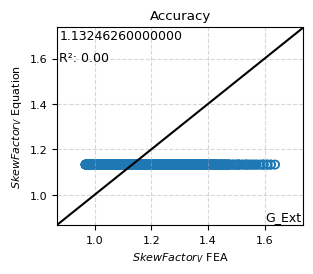

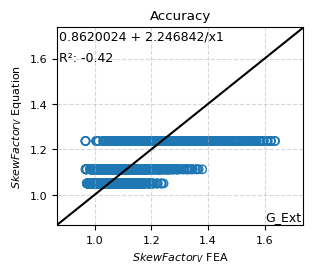

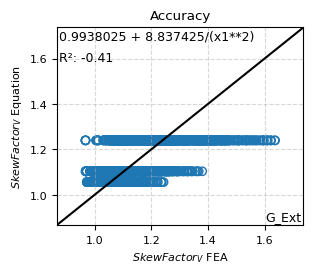

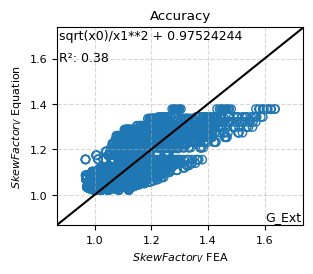

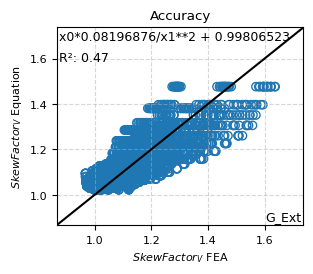

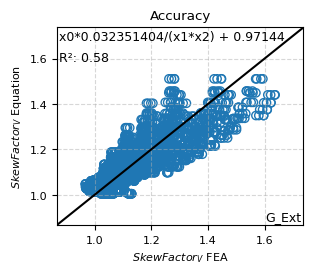

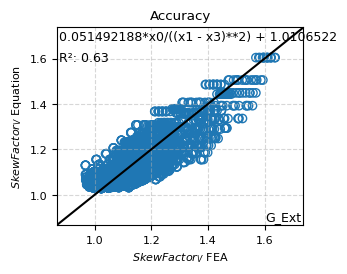

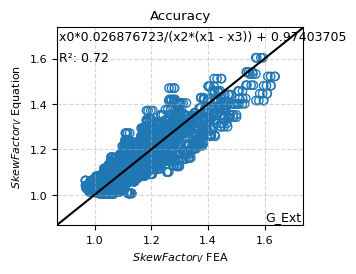

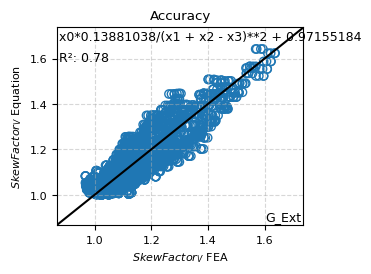

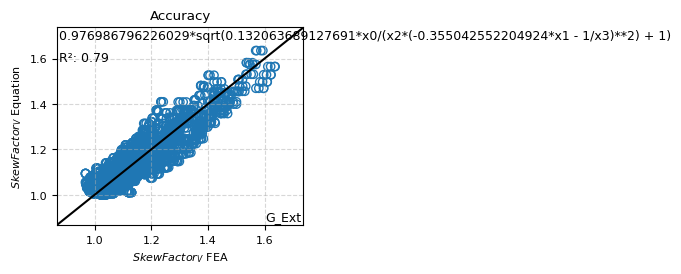

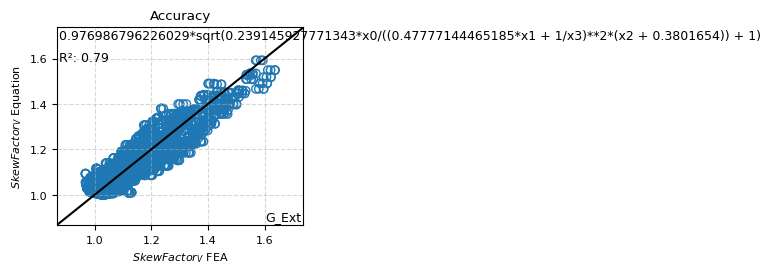

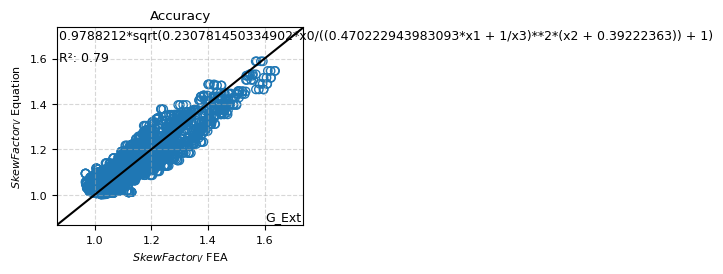

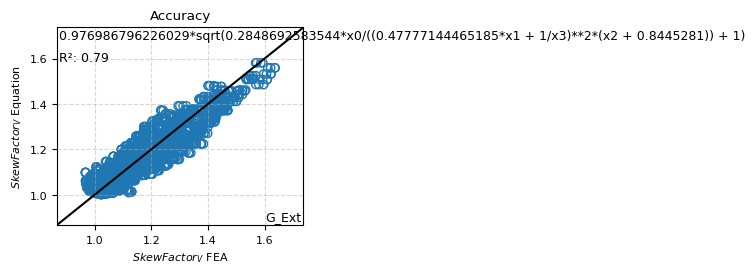

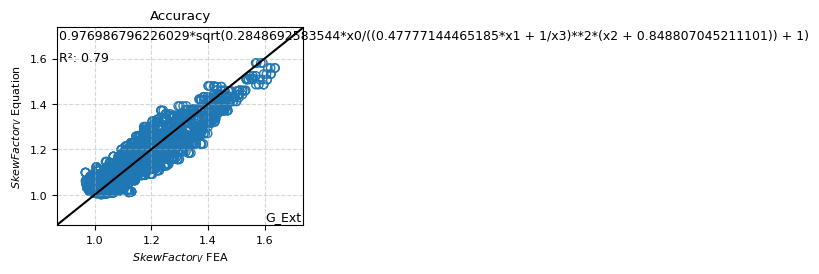

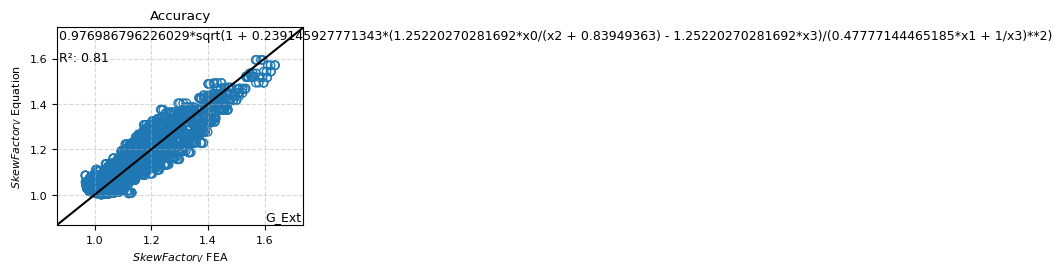

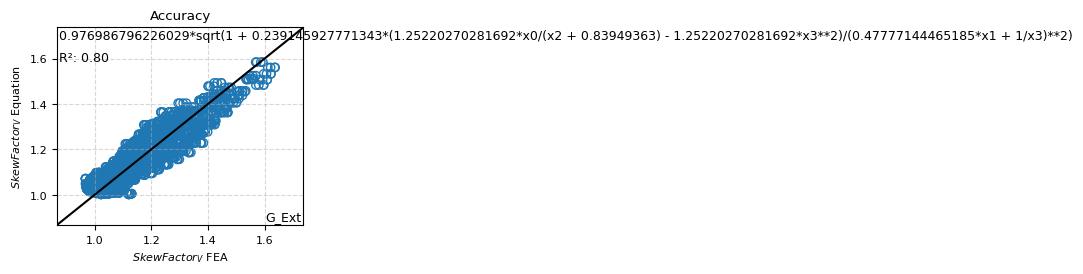

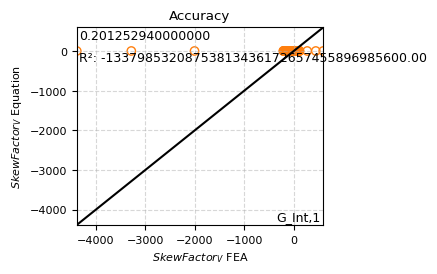

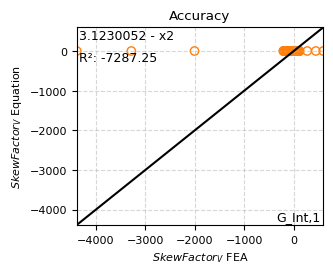

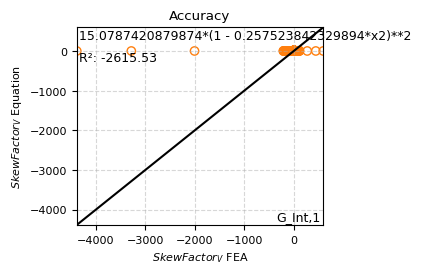

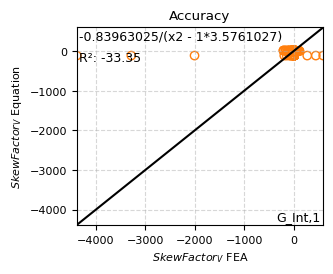

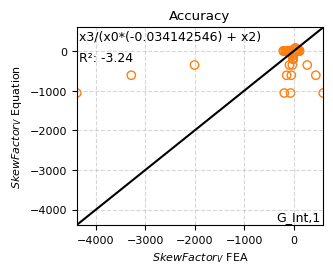

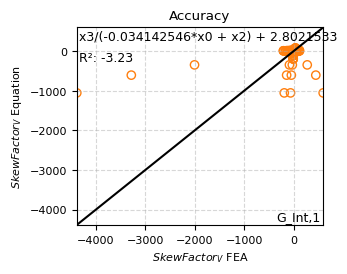

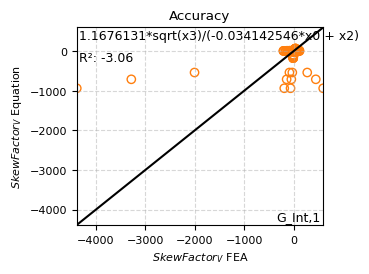

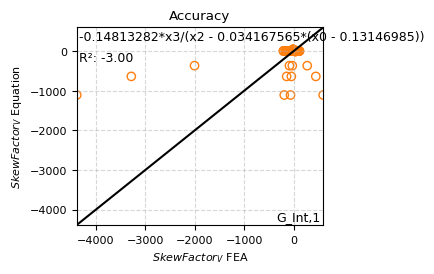

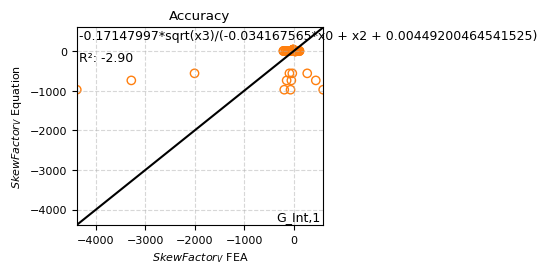

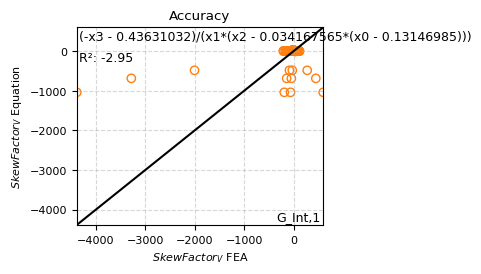

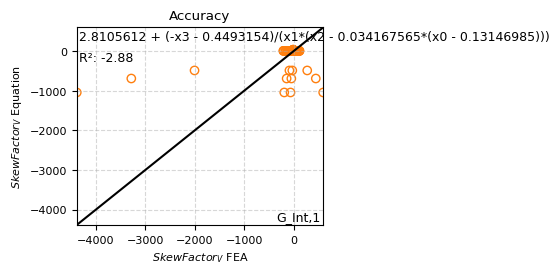

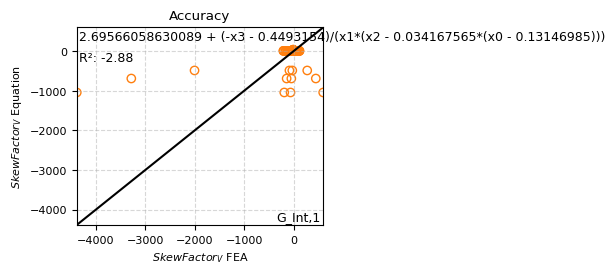

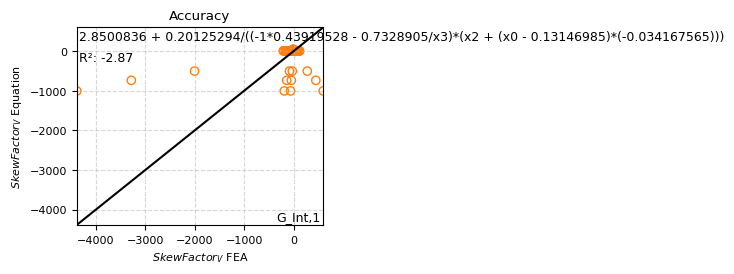

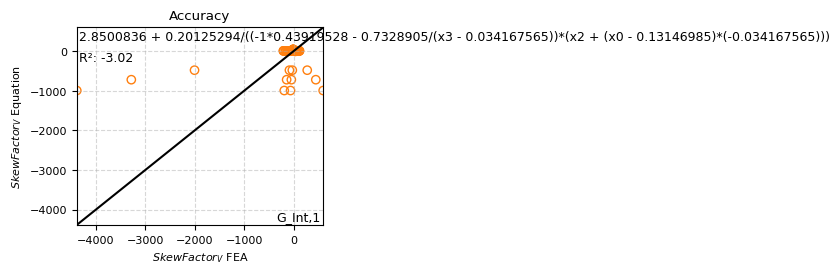

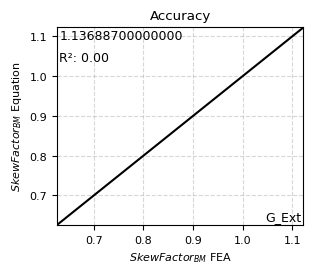

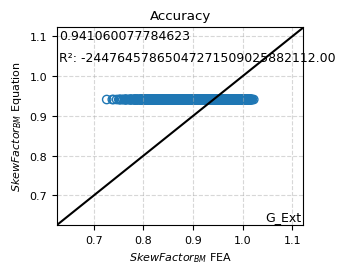

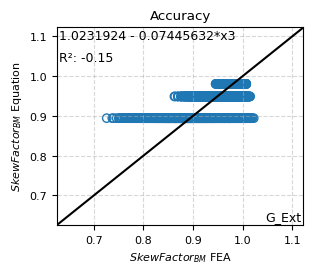

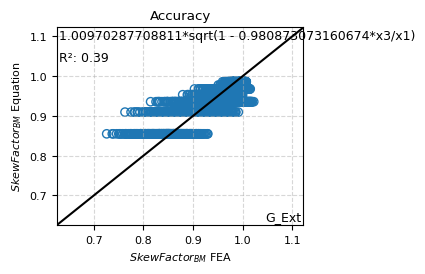

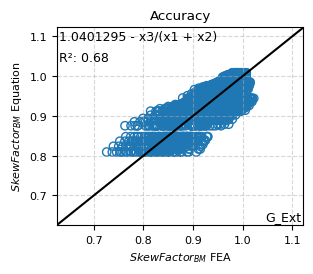

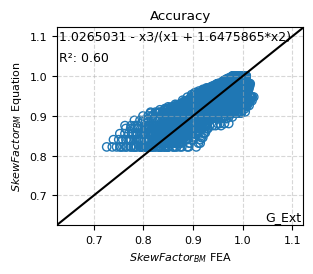

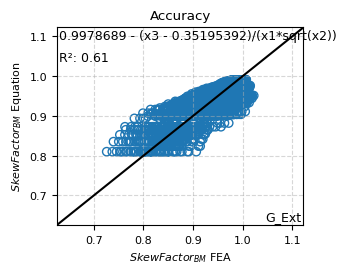

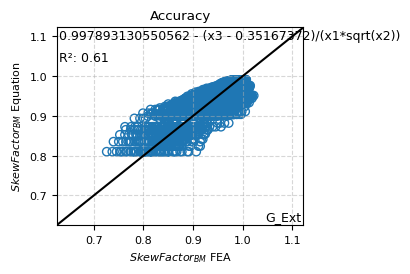

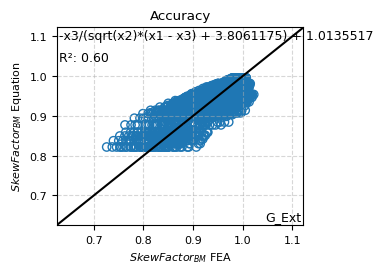

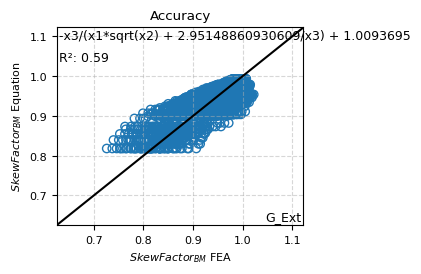

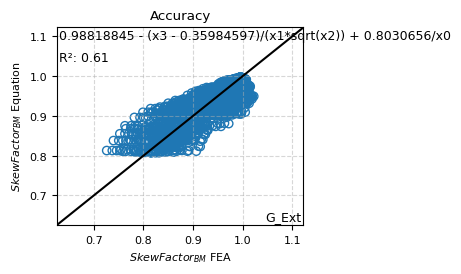

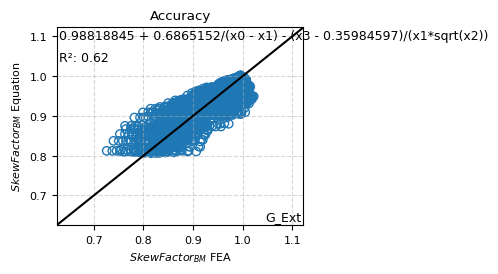

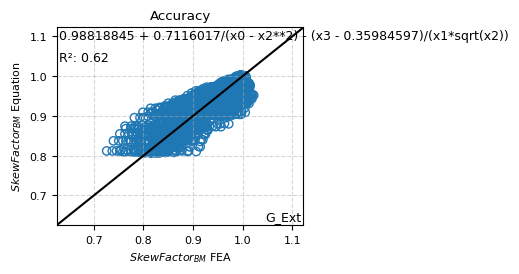

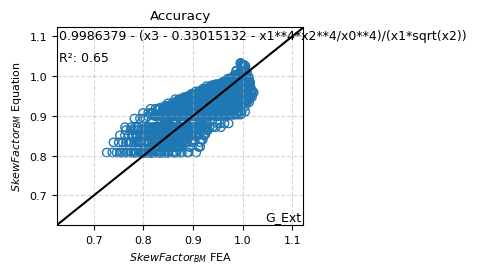

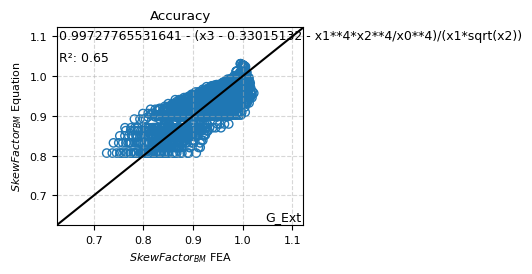

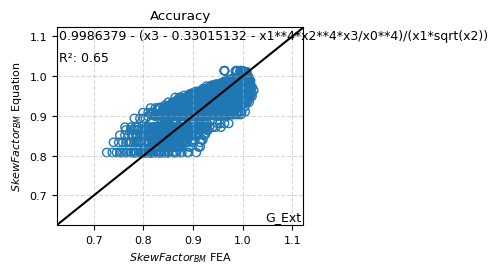

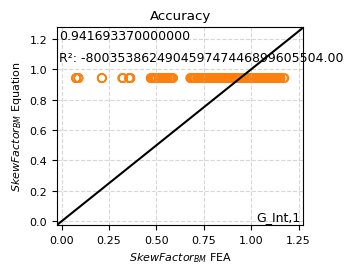

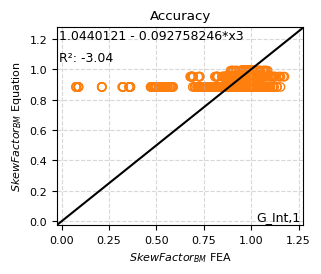

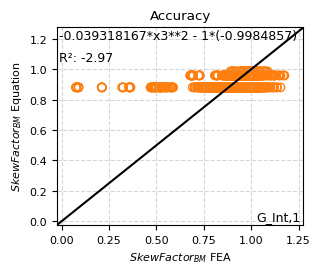

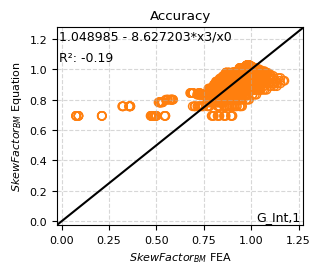

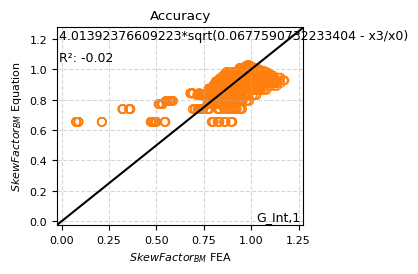

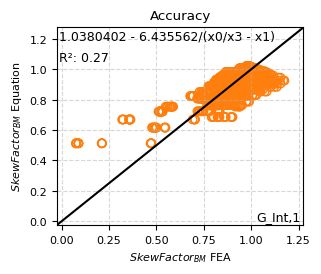

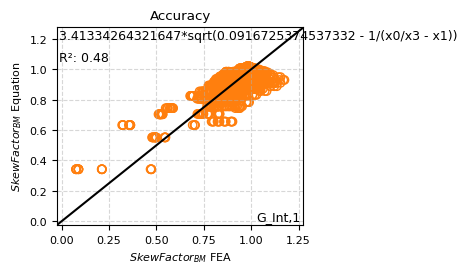

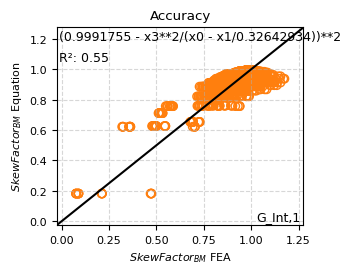

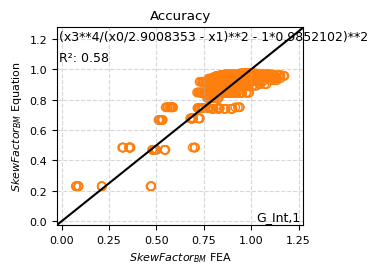

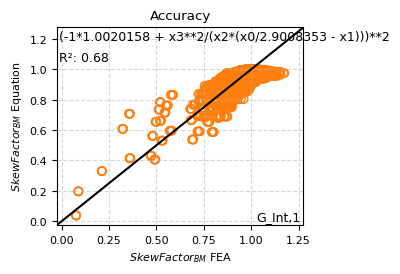

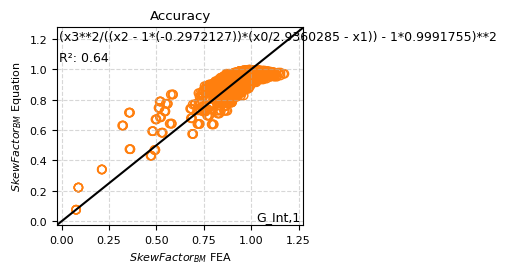

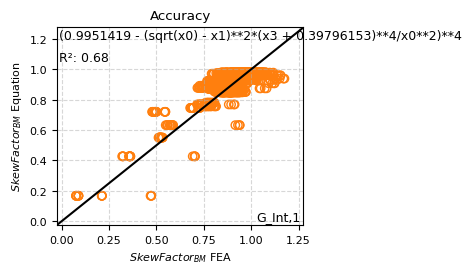

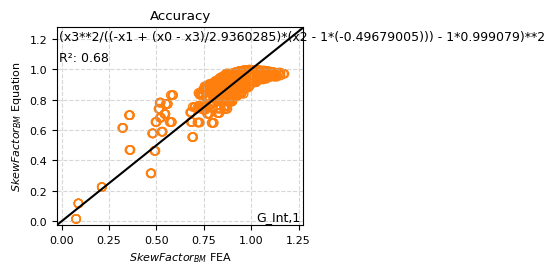

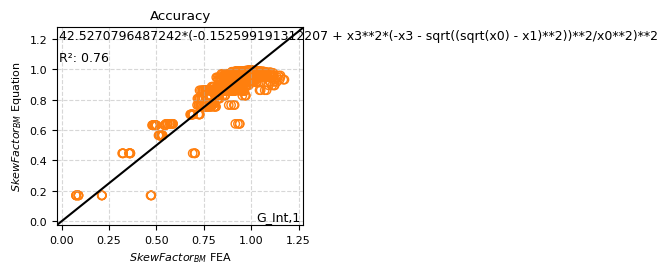

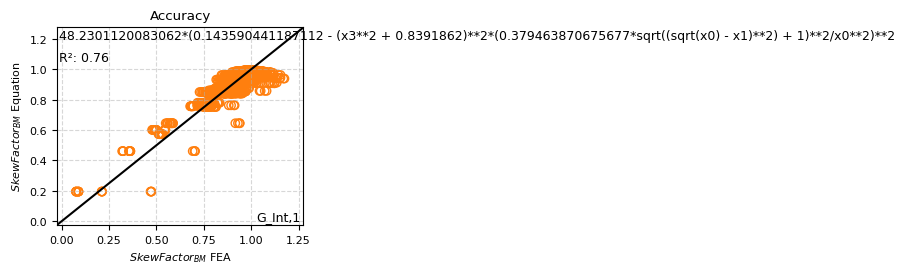

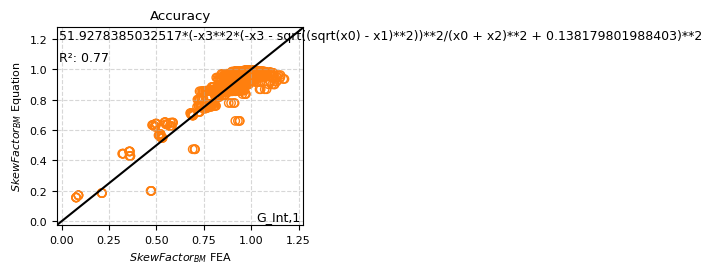

In [80]:
for index, y_output in enumerate(outputs):
    r2_list = []
    model_pkl_file = path / (output_names[index] + ".pkl")
    with open(model_pkl_file, 'rb') as file:
        model = pickle.load(file)
    X = np.stack((x_L, x_S, x_w_oh, x_tan_skew), axis=-1)
    y = y_output
    # model.fit(X, y)
    for i in range(len(model.equations_)):
        y_pred = model.predict(X,i)
        r2 = diagonal_plot(y, y_pred, output_labels[index], girder_names[index], model.sympy(i), output_names[index], i)
        r2_list.append(r2)
    print(r2_list)
    output_df = pd.DataFrame()
    output_df['R2'] = r2_list
    output_df.to_csv(output_names[index] + ".txt", index=False)
    print(output_df)


In [11]:
index = 2
model_pkl_file = path / (output_names[index] + ".pkl")
with open(model_pkl_file, 'rb') as file:
    model = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '/content/skew_correction_V_G2.pkl'

In [170]:
i = 5
model.sympy(i)

x3/(-0.034142546*x0 + x2) + 2.8021533

In [1]:
y_pred = model.predict(X,i)
y = outputs[index]
print("Default selection MSE:", np.power(y_pred - y, 2).mean())
r2 = r2_score(y_pred, y)
print(f"R²: {r2:.4f}")

NameError: name 'model' is not defined

[11.54815294  3.82218323  3.34375104 ...  2.31546134  2.06959277
  1.32168532]


-3.2348430098690653

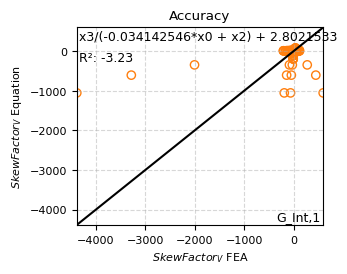

In [172]:
print(y_pred)
diagonal_plot(y, y_pred, output_labels[index], girder_names[index], model.sympy(i), output_names[index], i)